## Scaling to higher dimensions D ∈ {4, 8, 16}

Test whether TailedUniform's boundary advantage persists in higher dimensions despite sample dilution into tails.

In [1]:
# ABOUTME: Test NPE performance across dimensions (D=4, 8, 16) at varying distances
# ABOUTME: Compares Uniform vs TailedUniform priors with radial distance analysis

import numpy as np
import torch
import random

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [2]:
from toolbox.imports import *
from toolbox.distributions import TailedUniform, IndependentTailedUniform
from toolbox.evaluators import DistanceEvaluator

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

sns.set(style="whitegrid", context="paper", font_scale=1.2)

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


### Load trained models for all dimensions

6 total models: Uniform and TailedUniform (σ=0.3) at D=4, 8, 16.

In [ ]:
# Load all models from experiment-models folder
n_posterior_samples = 2000
dimensions = [4, 8, 16]

all_posteriors = {}

# Load both uniform and tailed models for each dimension
for dim in dimensions:
    # Load uniform model
    uniform_path = f'/home/x-ctirapongpra/scratch/tailed-uniform-sbi/experiment-models/dim-{dim}-sigma0.3/uniform/posterior.pkl'
    try:
        with open(uniform_path, 'rb') as f:
            posterior = pickle.load(f)
            key = f'Uniform-D={dim}'
            all_posteriors[key] = posterior
            print(f"Loaded: {key}")
    except FileNotFoundError:
        print(f"Not found: {uniform_path}")
    
    # Load tailed model
    tailed_path = f'/home/x-ctirapongpra/scratch/tailed-uniform-sbi/experiment-models/dim-{dim}-sigma0.3/taileduniform/posterior.pkl'
    try:
        with open(tailed_path, 'rb') as f:
            posterior = pickle.load(f)
            key = f'TailedUniform-D={dim}'
            all_posteriors[key] = posterior
            print(f"Loaded: {key}")
    except FileNotFoundError:
        print(f"Not found: {tailed_path}")

print(f"\nTotal models loaded: {len(all_posteriors)}")

Loaded: Uniform-D=4
Loaded: Tailed-D=4
Loaded: Uniform-D=8
Loaded: Tailed-D=8
Loaded: Uniform-D=16
Loaded: Tailed-D=16

Total models loaded: 6


### Evaluate for each dimension separately
Since each dimension requires different parameter ranges and simulators, we'll evaluate them one at a time.

In [4]:
# Store results for all dimensions
all_c2st_results = {}

for dim in dimensions:
    print(f"\n{'='*80}")
    print(f"Evaluating dimension {dim}")
    print(f"{'='*80}\n")
    
    # Setup parameters and evaluator for this dimension
    param_ranges = [(-1.0, 1.0) for _ in range(dim)]
    param_width = 2.0
    
    # Task setup
    task = GaussianLinear(dim=dim, prior_scale=param_width/2)
    simulator = task.get_simulator()
    
    # Create evaluator
    evaluator = DistanceEvaluator(simulator, param_ranges, task)
    
    # Create test points (using fewer points for faster evaluation)
    test_points, distance_bins = evaluator.create_test_points(n_points_per_radius=40)
    print(f"Created {len(test_points)} test points for dimension {dim}")
    
    # Get posteriors for this dimension
    dim_posteriors = {
        f'Uniform-D={dim}': all_posteriors.get(f'Uniform-D={dim}'),
        f'TailedUniform-D={dim}': all_posteriors.get(f'TailedUniform-D={dim}')
    }
    # Remove None values
    dim_posteriors = {k: v for k, v in dim_posteriors.items() if v is not None}
    
    # Evaluate all models for this dimension
    results_all = evaluator.evaluate_all(dim_posteriors, test_points, n_samples=n_posterior_samples)
    
    # Compute C2ST vs Reference for each model
    def compute_c2st_vs_reference(results, distance_bins, evaluator):
        """Compute C2ST vs Reference for all models at each distance bin"""
        model_names = [k for k in results.keys() if k not in ['test_points', 'observations', 'Reference']]
        
        distance_bin_names = ['center', 'r=0.25', 'r=0.5', 'r=0.75', 'r=1.0', '2sigma-extrap']
        c2st_by_model_and_distance = {}
        
        for model_name in model_names:
            c2st_by_model_and_distance[model_name] = {}
            
            for bin_name in distance_bin_names:
                indices = np.where(distance_bins == bin_name)[0]
                
                if len(indices) == 0:
                    c2st_by_model_and_distance[model_name][bin_name] = []
                    continue
                
                # Compute C2ST vs Reference for this model at this distance bin
                c2st_vals = []
                for idx in indices:
                    c2st_val = evaluator.c2st(results[model_name][idx], results['Reference'][idx])
                    c2st_vals.append(c2st_val)
                
                c2st_by_model_and_distance[model_name][bin_name] = c2st_vals
        
        return c2st_by_model_and_distance
    
    c2st_results = compute_c2st_vs_reference(results_all, distance_bins, evaluator)
    
    # Store results for this dimension
    all_c2st_results[dim] = c2st_results
    
    # Show summary
    print(f"\nC2ST vs Reference Summary for D={dim}:")
    print("=" * 80)
    for model_name in sorted(c2st_results.keys()):
        print(f"\n{model_name}:")
        for bin_name in ['center', 'r=0.25', 'r=0.5', 'r=0.75', 'r=1.0', '2sigma-extrap']:
            if c2st_results[model_name][bin_name]:
                vals = np.array(c2st_results[model_name][bin_name])
                print(f"  {bin_name:12s}: {np.mean(vals):.3f} ± {np.std(vals):.3f}")


Evaluating dimension 4

Created 201 test points for dimension 4


Tailed-D=4: 100%|██████████| 201/201 [00:09<00:00, 21.42it/s]



C2ST vs Reference Summary for D=4:

Tailed-D=4:
  center      : 0.514 ± 0.000
  r=0.25      : 0.469 ± 0.019
  r=0.5       : 0.467 ± 0.020
  r=0.75      : 0.457 ± 0.019
  r=1.0       : 0.454 ± 0.020
  2sigma-extrap: 0.451 ± 0.020

Uniform-D=4:
  center      : 0.459 ± 0.000
  r=0.25      : 0.469 ± 0.038
  r=0.5       : 0.453 ± 0.045
  r=0.75      : 0.432 ± 0.072
  r=1.0       : 0.379 ± 0.074
  2sigma-extrap: 0.319 ± 0.105

Evaluating dimension 8

Created 201 test points for dimension 8


Tailed-D=8: 100%|██████████| 201/201 [00:24<00:00,  8.23it/s]



C2ST vs Reference Summary for D=8:

Tailed-D=8:
  center      : 0.452 ± 0.000
  r=0.25      : 0.447 ± 0.020
  r=0.5       : 0.440 ± 0.018
  r=0.75      : 0.441 ± 0.022
  r=1.0       : 0.431 ± 0.022
  2sigma-extrap: 0.427 ± 0.021

Uniform-D=8:
  center      : 0.486 ± 0.000
  r=0.25      : 0.453 ± 0.027
  r=0.5       : 0.445 ± 0.037
  r=0.75      : 0.420 ± 0.074
  r=1.0       : 0.399 ± 0.068
  2sigma-extrap: 0.357 ± 0.090

Evaluating dimension 16

Created 201 test points for dimension 16


Tailed-D=16: 100%|██████████| 201/201 [00:49<00:00,  4.05it/s]



C2ST vs Reference Summary for D=16:

Tailed-D=16:
  center      : 0.427 ± 0.000
  r=0.25      : 0.419 ± 0.019
  r=0.5       : 0.422 ± 0.018
  r=0.75      : 0.414 ± 0.018
  r=1.0       : 0.408 ± 0.014
  2sigma-extrap: 0.400 ± 0.021

Uniform-D=16:
  center      : 0.455 ± 0.000
  r=0.25      : 0.430 ± 0.032
  r=0.5       : 0.427 ± 0.043
  r=0.75      : 0.430 ± 0.031
  r=1.0       : 0.397 ± 0.061
  2sigma-extrap: 0.383 ± 0.067


For each D, create appropriate simulator, generate test points, evaluate posteriors, and compute C2ST.

### Plot C2ST vs distance stratified by dimension (Figure 8)

TailedUniform advantage grows in higher dimensions; boundary dominance outweighs tail dilution effects.

Saved: experiment-figures/c2st-vs-distance-by-dimension.pdf


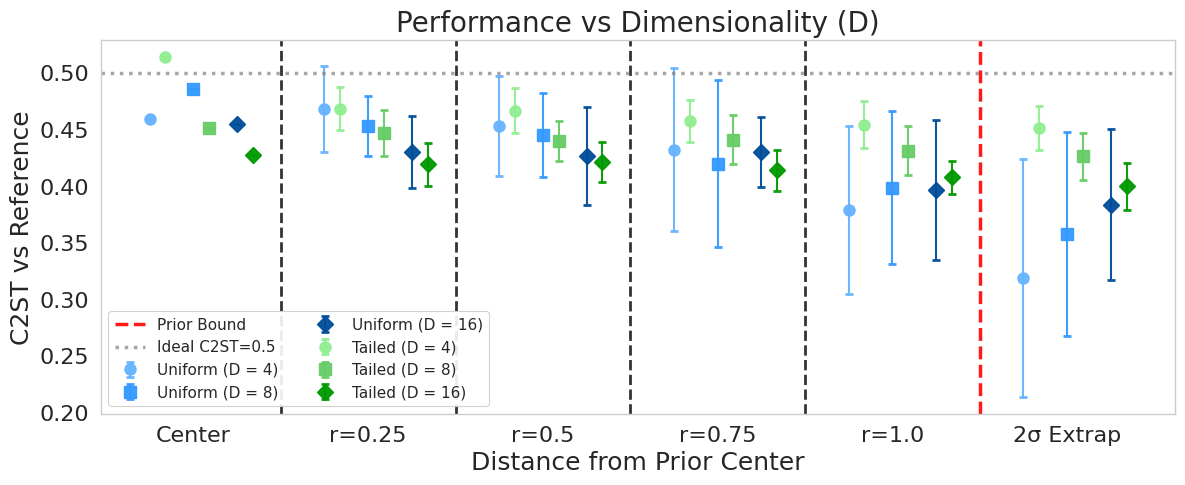

In [5]:
def plot_c2st_vs_distance_by_dimension(all_c2st_results, dimensions, figsize=(12, 5)):
    """Plot C2ST vs distance for all dimensions in a single plot"""
    distance_bins = ['center', 'r=0.25', 'r=0.5', 'r=0.75', 'r=1.0', '2sigma-extrap']
    bin_labels = ['Center', 'r=0.25', 'r=0.5', 'r=0.75', 'r=1.0', '2σ Extrap']
    x_positions = np.arange(len(distance_bins))

    plt.figure(figsize=figsize)

    # Uniform models - shades of blue (shifted left)
    uniform_styles = {
        4: {'color': '#66b3ff', 'marker': 'o', 'linestyle': '-', 'offset': -0.25},
        8: {'color': '#3399ff', 'marker': 's', 'linestyle': '-', 'offset': 0.00},
        16: {'color': '#004d99', 'marker': 'D', 'linestyle': '-', 'offset': 0.25}
    }

    # Tailed models - shades of green (shifted right)
    tailed_styles = {
        4: {'color': '#90ee90', 'marker': 'o', 'linestyle': '--', 'offset': -0.16},
        8: {'color': '#66cc66', 'marker': 's', 'linestyle': '--', 'offset': 0.09},
        16: {'color': '#009900', 'marker': 'D', 'linestyle': '--', 'offset': 0.34}
    }

    # Plot Uniform models
    for dim in dimensions:
        model_name = f'Uniform-D={dim}'
        if dim in all_c2st_results and model_name in all_c2st_results[dim]:
            mean_c2st = []
            std_c2st = []
            valid_x = []

            for i, bin_name in enumerate(distance_bins):
                if all_c2st_results[dim][model_name][bin_name]:  # Check if bin has data
                    vals = np.array(all_c2st_results[dim][model_name][bin_name])
                    mean_c2st.append(np.mean(vals))
                    std_c2st.append(np.std(vals))
                    valid_x.append(x_positions[i] + uniform_styles[dim]['offset'])

            if mean_c2st:  # Only plot if we have data
                style = uniform_styles[dim]
                plt.errorbar(valid_x, mean_c2st, yerr=std_c2st,
                            fmt=style['marker'],
                            label=f'Uniform (D = {dim})',
                            color=style['color'],
                            capsize=3, capthick=2, linewidth=0, markersize=8,
                            barsabove=True, elinewidth=1.5, alpha=0.95)

    # Plot Tailed models
    for dim in dimensions:
        model_name = f'TailedUniform-D={dim}'
        if dim in all_c2st_results and model_name in all_c2st_results[dim]:
            mean_c2st = []
            std_c2st = []
            valid_x = []

            for i, bin_name in enumerate(distance_bins):
                if all_c2st_results[dim][model_name][bin_name]:  # Check if bin has data
                    vals = np.array(all_c2st_results[dim][model_name][bin_name])
                    mean_c2st.append(np.mean(vals))
                    std_c2st.append(np.std(vals))
                    valid_x.append(x_positions[i] + tailed_styles[dim]['offset'])

            if mean_c2st:  # Only plot if we have data
                style = tailed_styles[dim]
                plt.errorbar(valid_x, mean_c2st, yerr=std_c2st,
                            fmt=style['marker'],
                            label=f'Tailed (D = {dim})',
                            color=style['color'],
                            capsize=3, capthick=2, linewidth=0, markersize=8,
                            barsabove=True, elinewidth=1.5, alpha=0.95)

    # Add vertical dashed lines between distance bins
    for i in range(len(x_positions) - 1):
        separator_x = (x_positions[i] + x_positions[i + 1]) / 2
        # Last separator (between r=1.0 and 2sigma-extrap) is red and labeled
        if i == len(x_positions) - 2:
            plt.axvline(separator_x, color='red', linestyle='--', linewidth=2.5, 
                       alpha=0.9, zorder=0, label='Prior Bound')
        else:
            plt.axvline(separator_x, color='black', linestyle='--', linewidth=2.0, 
                       alpha=0.8, zorder=0)

    plt.axhline(0.5, color='gray', linestyle=':', linewidth=2.5, label='Ideal C2ST=0.5', alpha=0.7)
    plt.xticks(x_positions, bin_labels, fontsize=14)
    plt.xlabel('Distance from Prior Center', fontsize=18)
    plt.ylabel('C2ST vs Reference', fontsize=18)
    plt.title('Performance vs Dimensionality (D)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(fontsize=11, loc='best', ncol=2, framealpha=0.9)
    plt.grid(False)
    plt.tight_layout()

    return plt.gcf()

sns.set(style="whitegrid", context="paper", font_scale=1.2)
fig = plot_c2st_vs_distance_by_dimension(all_c2st_results, dimensions)

# Save to PDF
os.makedirs('experiment-figures', exist_ok=True)
plt.savefig('experiment-figures/c2st-vs-distance-by-dimension.pdf', dpi=300, bbox_inches='tight')
print("Saved: experiment-figures/c2st-vs-distance-by-dimension.pdf")

plt.show()